# **3. LiDAR Point clouds to 3D surfaces**

In this final tutorial, we'll see how PyGMT can be used
to perform more advanced geoprocessing workflows
such as filtering and interpolation of point datasets to grids.
At the end, we'll also experiment with making some 3D perspective plots
of a Digital Surface Model (DSM) we produced through this exercise!

## **Getting started**

Let's start by importing the Python libraries we'll be using.
We'll be using [laspy](https://github.com/laspy/laspy) to read in LAZ LiDAR files,
and [rioxarray](https://corteva.github.io/rioxarray) to export our DSM to a GeoTIFF later on.
Hopefully [pandas](https://pandas.pydata.org) and [pygmt](https://www.pygmt.org)
will be familiar to you by now.

In [1]:
import laspy
import pandas as pd
import pygmt
import rioxarray

## **3.1 Loading a LiDAR point cloud**

This time we'll be visiting [Picton](https://en.wikipedia.org/wiki/Picton%2C_New_Zealand)
which is a town 65 km west of New Zealand's capital Wellington.
They've had a fairly recent LiDAR survey done between May and September 2018,
with the point cloud and derived products published at 
[OpenTopography](https://doi.org/10.5069/G91R6NNG) and
[LINZ Data Service](https://data.linz.govt.nz/layer/103538-marlborough-lidar-index-tiles-2018/)
(under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license).
This tutorial is actually inspired by this
[blog post](https://medium.com/on-location/from-points-to-pixels-creating-digital-elevation-models-from-open-topography-point-clouds-abe616d06860)
published by LINZ.

First though, we'll need to download a sample file to play with.
Luckily for us,
there is a function called [pygmt.which](https://www.pygmt.org/dev/api/generated/pygmt.which)
that has to ability to do just that!
The download="l" option can be used to download a remote file to our local working directory.

In [2]:
lazfile = pygmt.which(
    fname="https://cloud.sdsc.edu/v1/AUTH_opentopography/PC_Bulk/NZ18_Marlbo/CL2_BQ29_2018_1000_1607.laz",
    download="l"
)
print(lazfile)

CL2_BQ29_2018_1000_1607.laz


Now we can use [laspy](https://github.com/laspy/laspy) to read in our example LAZ file
into a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).
The data will be kept in a variable called 'df' which stands for dataframe.

In [3]:
with laspy.file.File(lazfile, mode="r") as lasdata:
    df = pd.DataFrame(data=lasdata.points["point"])
    df.X = lasdata.get_x_scaled()
    df.Y = lasdata.get_y_scaled()
    df.Z = lasdata.get_z_scaled()

### **Quick data preview**

Let's see how many data points (rows) we have,
get the bounding box region of our study area,
and also take a look at a snippet of our table.

In [4]:
region = [df.X.min(), df.X.max(), df.Y.min(), df.Y.max()]
print(f"Total of {len(df)} data points, covering region {region}")
df.head()

Total of 2082563 data points, covering region [1686880.002, 1687359.998, 5430480.004, 5431199.996]


X            Y       Z  intensity  flag_byte  raw_classification  \
0  1686983.789  5430480.022  19.200         38          9                   1   
1  1686985.165  5430480.076  19.984         42         73                   1   
2  1686984.878  5430480.295  19.952         50         73                   1   
3  1686984.608  5430480.506  19.834         31         81                   1   
4  1686984.548  5430480.633  18.732         19         82                   1   

   scan_angle_rank  user_data  pt_src_id      gps_time  
0                6          1       1325  2.192863e+08  
1                6          1       1325  2.192863e+08  
2                6          1       1325  2.192863e+08  
3                6          1       1325  2.192863e+08  
4                6          1       1325  2.192863e+08

More than 2 million points, that's a lot!
Let's try to take a quick look of our LiDAR elevation points on a map.
PyGMT *can* plot these many points, but it might take a long time,
so let's do a quick filter by taking every
[n-th row](https://stackoverflow.com/questions/25055712/pandas-every-nth-rowhttps://stackoverflow.com/questions/25055712/pandas-every-nth-row)
from our dataframe table.

In [5]:
df_filtered = df.iloc[::20]
print(f"Filtered down to {len(df_filtered)} data points")

Filtered down to 104129 data points


Now we can visualize these quickly on a map with PyGMT.

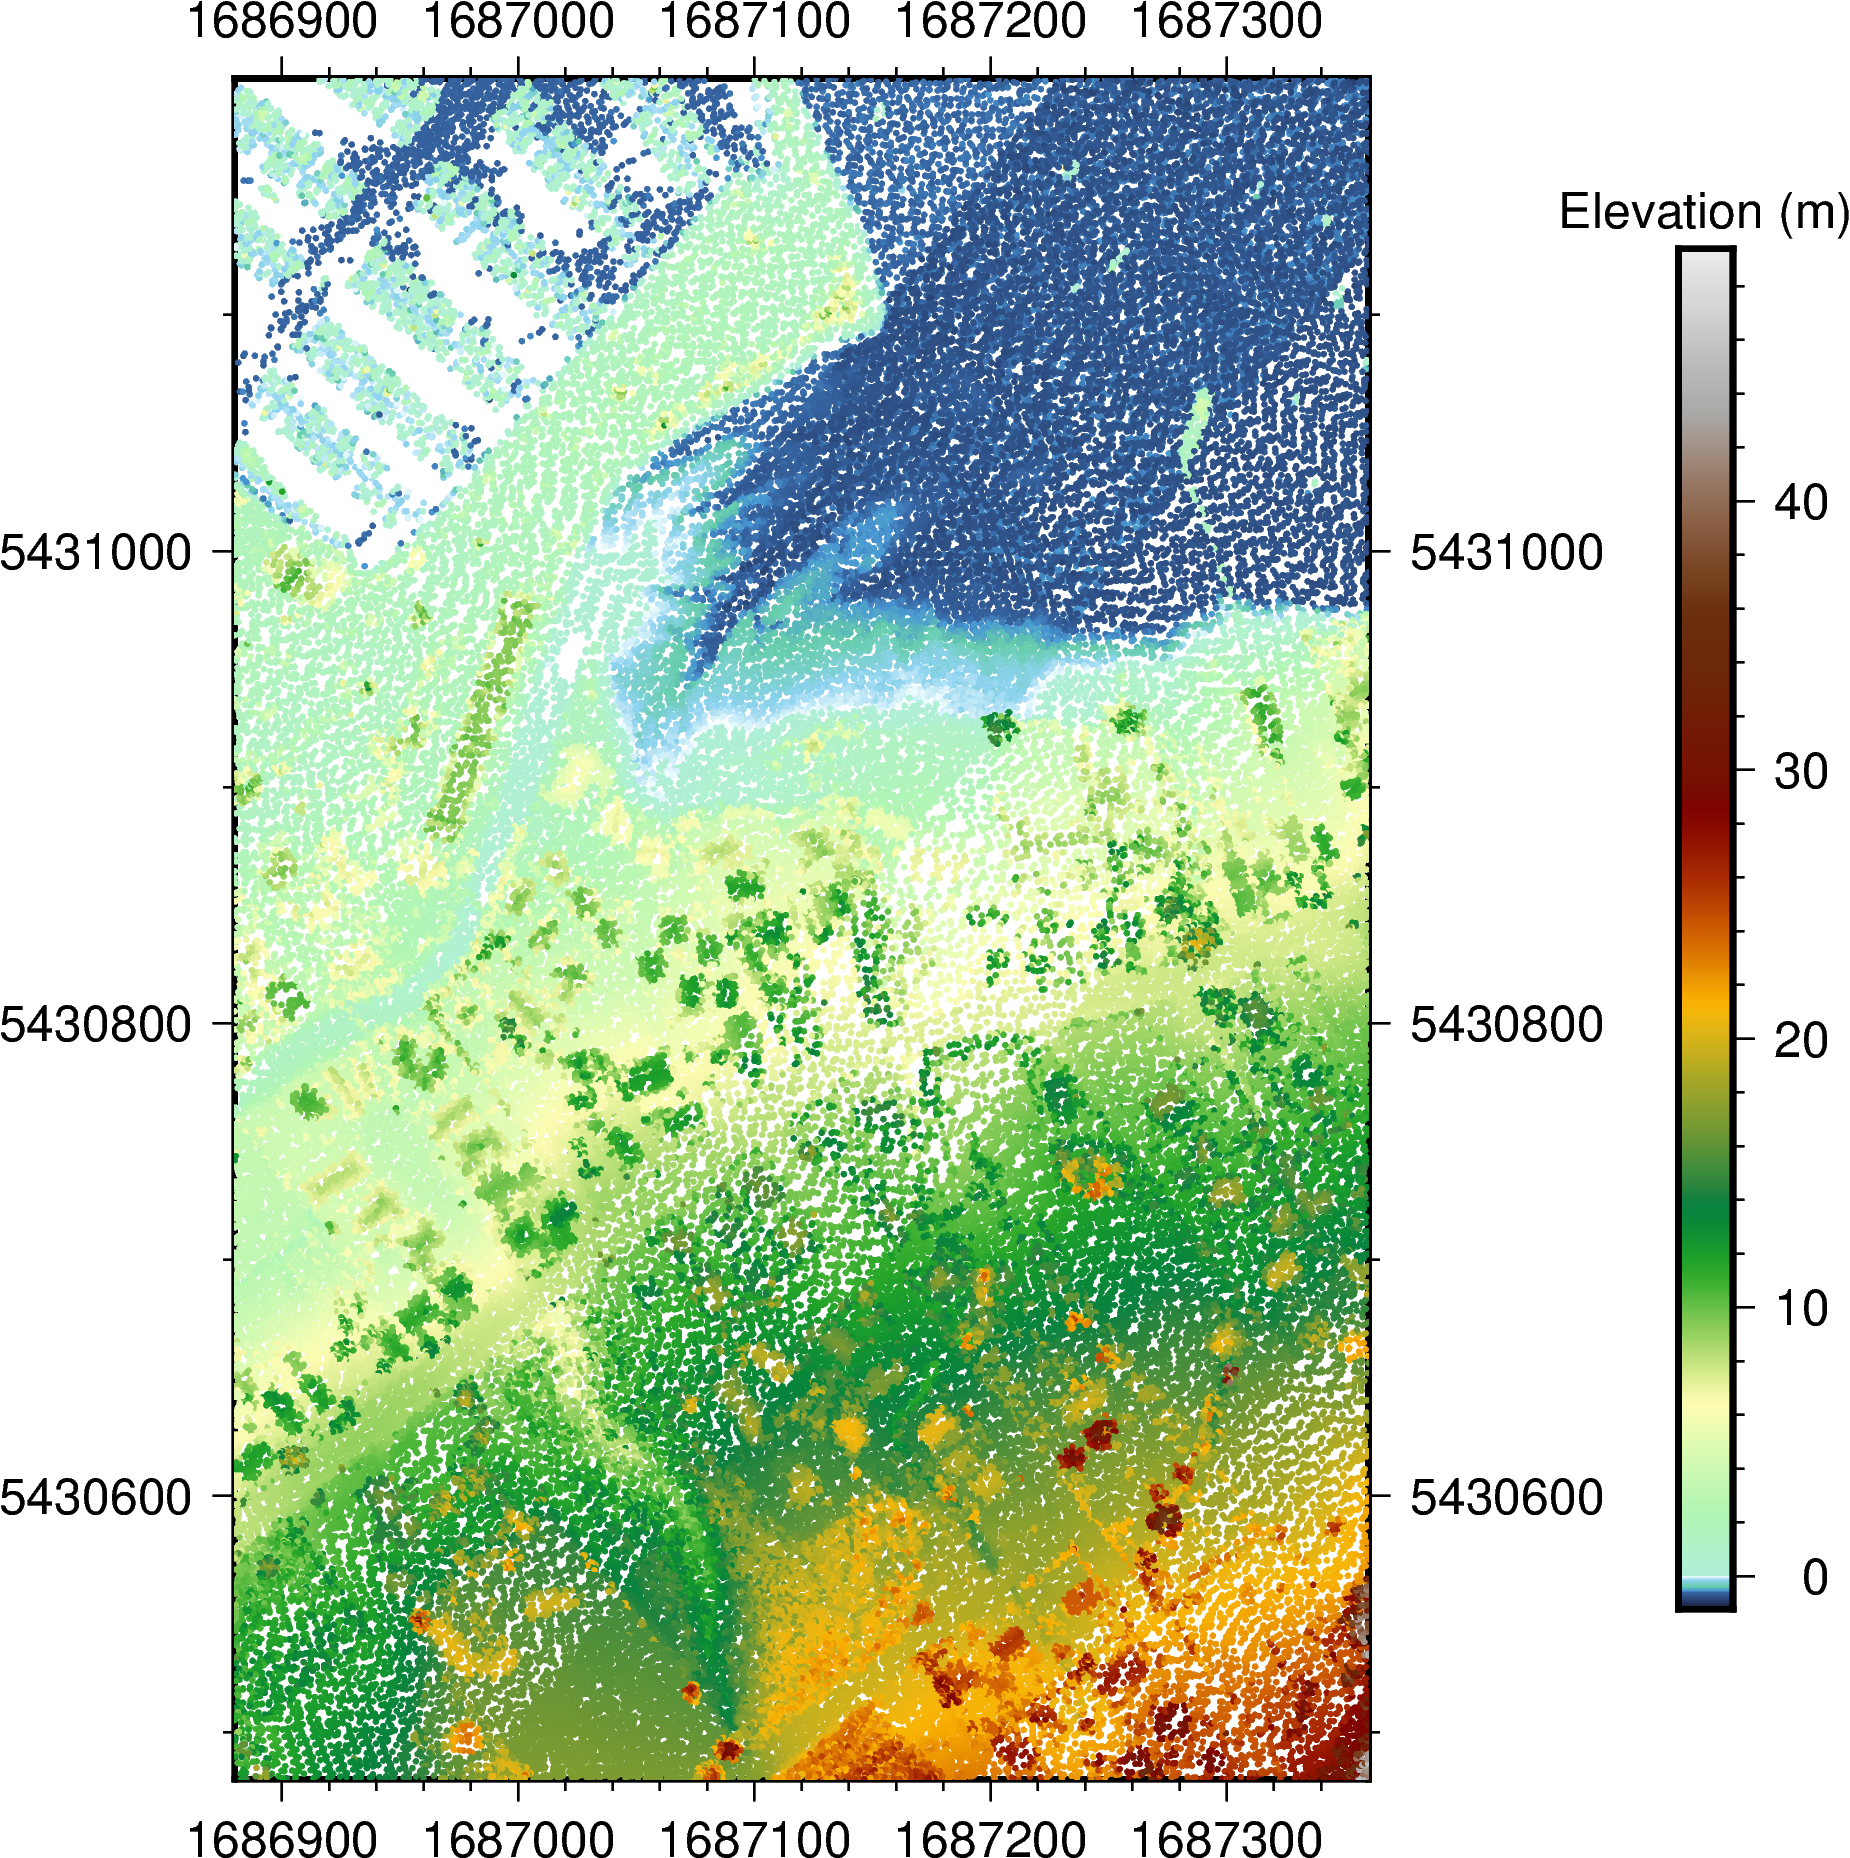

In [6]:
fig = pygmt.Figure()
fig.basemap(frame=True, region=region, projection="x1:5000")
pygmt.makecpt(cmap="earth", series=[df.Z.min(), df.Z.max()])
fig.plot(x=df_filtered.X, y=df_filtered.Y, color=df_filtered.Z, style="c0.05c", cmap=True)
fig.colorbar(position="JMR", frame=["af", 'y+l"Elevation (m)"'], X="1.5c")
fig.show()

It's hard to make out what the objects are,
but hopefully you'll see what looks like a wharf with docks on the top left corner.
This is basically showing us a part of the port of Picton.

## **3.2 Creating a Digital Surface Model (DSM)**

Let's now produce a digital surface model from our point cloud.
We'll first do some proper spatial data cleaning using both
[pandas](https://pandas.pydata.org) and [pygmt](https://www.pygmt.org).

The first step is to remove the LiDAR points classified as water
(see [ASPRS LAS Specification](https://www.asprs.org/a/society/committees/standards/LAS_1_4_r13.pdf)),
which is done by querying all the points that are not '9'.

In [7]:
df = df.query(expr="raw_classification != 9")

Next, we'll use the [blockmedian](https://pygmt-git-foss4g2019oceania.gmt.now.sh/api/generated/pygmt.blockmedian.html#pygmt.blockmedian)
to trim the points down spatially.
By default, this function will compute a single median elevation for every pixel on an equally spaced grid.

For a DSM though,
we should technically be picking the highest elevation instead of the median.
We'll tell blockmedian to use the 99th [quantile](https://docs.generic-mapping-tools.org/latest/blockmedian.html#t) (T) instead,
and set our output grid spacing to be exactly 1 m (1+e).
Note that we'll only be taking the X, Y, and Z (elevation) columns for this.

In [8]:
df_trimmed = pygmt.blockmedian(table=df[["X", "Y", "Z"]], T=0.99, spacing="1+e", region=region)
df_trimmed

X            Y       Z
0       1686915.140  5431199.548   0.603
1       1686916.485  5431199.862   0.594
2       1686917.390  5431199.994   2.737
3       1686918.476  5431199.958   3.767
4       1686919.458  5431199.996   3.699
...             ...          ...     ...
279987  1687356.151  5430480.333  45.379
279988  1687357.466  5430480.495  44.581
279989  1687358.485  5430480.436  44.900
279990  1687359.442  5430480.492  44.543
279991  1687359.860  5430480.384  41.803

[279992 rows x 3 columns]

Lastly, we'll use [pygmt.surface](https://www.pygmt.org/dev/api/generated/pygmt.surface)
to produce a grid from the x, y, z data points.
We'll make sure to set our desired grid spacing to be exactly 1 m (1+e) again,
and also set a tension factor (T) of 0.35 which is suitable for steep topography
(since we have some buildings with 'steep' vertical edges).
Note that this might take some time to run.

In [9]:
grid = pygmt.surface(
    x=df_trimmed.X,
    y=df_trimmed.Y,
    z=df_trimmed.Z,
    spacing="1+e",
    region=region,
    T=0.35
)

Let's take a look at the output.
The grid will be returned as an
[xarray.Dataset](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html#xarray.Dataset),
with each pixel's elevation stored in the data variable 'z'.

In [10]:
grid

<xarray.Dataset>
Dimensions:  (x: 481, y: 721)
Coordinates:
  * x        (x) float64 1.687e+06 1.687e+06 1.687e+06 ... 1.687e+06 1.687e+06
  * y        (y) float64 5.43e+06 5.43e+06 5.43e+06 ... 5.431e+06 5.431e+06
Data variables:
    z        (y, x) float32 13.953947 12.10167 ... -0.63025296 -0.62186396
Attributes:
    Conventions:  CF-1.7
    title:        Data gridded with continuous surface splines in tension
    history:      surface @GMTAPI@-000000 -G/tmp/pygmt-5xjed_l7.nc -I1+e -R16...
    GMT_version:  6.0.0 [64-bit]

To look at the actual elevation values,
we need to call `grid.z` which gives us an
[xarray.DataArray](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html#xarray.DataArray)
(i.e. an xarray.DataArray is one variable inside of an xarray.Dataset).

In [11]:
grid.z

<xarray.DataArray 'z' (y: 721, x: 481)>
array([[13.953947  , 12.10167   , 12.092232  , ..., 45.431038  ,
        45.27581   , 42.278114  ],
       [13.312523  , 12.448528  , 12.324875  , ..., 44.99866   ,
        44.733265  , 41.334     ],
       [11.536291  , 12.437575  , 12.989161  , ..., 44.057205  ,
        43.419308  , 40.61511   ],
       ...,
       [ 0.5183164 ,  0.2624521 , -0.11619133, ..., -0.587479  ,
        -0.5811438 , -0.5722809 ],
       [-0.34100035, -0.48919106, -0.65438604, ..., -0.61028737,
        -0.6043588 , -0.5957697 ],
       [-0.8962013 , -0.9611594 , -1.0210123 , ..., -0.63588524,
        -0.63025296, -0.62186396]], dtype=float32)
Coordinates:
  * x        (x) float64 1.687e+06 1.687e+06 1.687e+06 ... 1.687e+06 1.687e+06
  * y        (y) float64 5.43e+06 5.43e+06 5.43e+06 ... 5.431e+06 5.431e+06
Attributes:
    long_name:     z
    actual_range:  [-2.62938786 49.01221466]

## **3.3 Plotting a Digital Surface Model (DSM)**

### **Plotting in 2D**

Now we can plot our Digital Surface Model (DSM) grid!
Since [grdimage](https://www.pygmt.org/dev/api/generated/pygmt.Figure.grdimage)
requires our grid to be an xarray.DataArray instead of an xarray.Dataset,
we'll need to pass in 'grid.z' instead of just 'grid'.

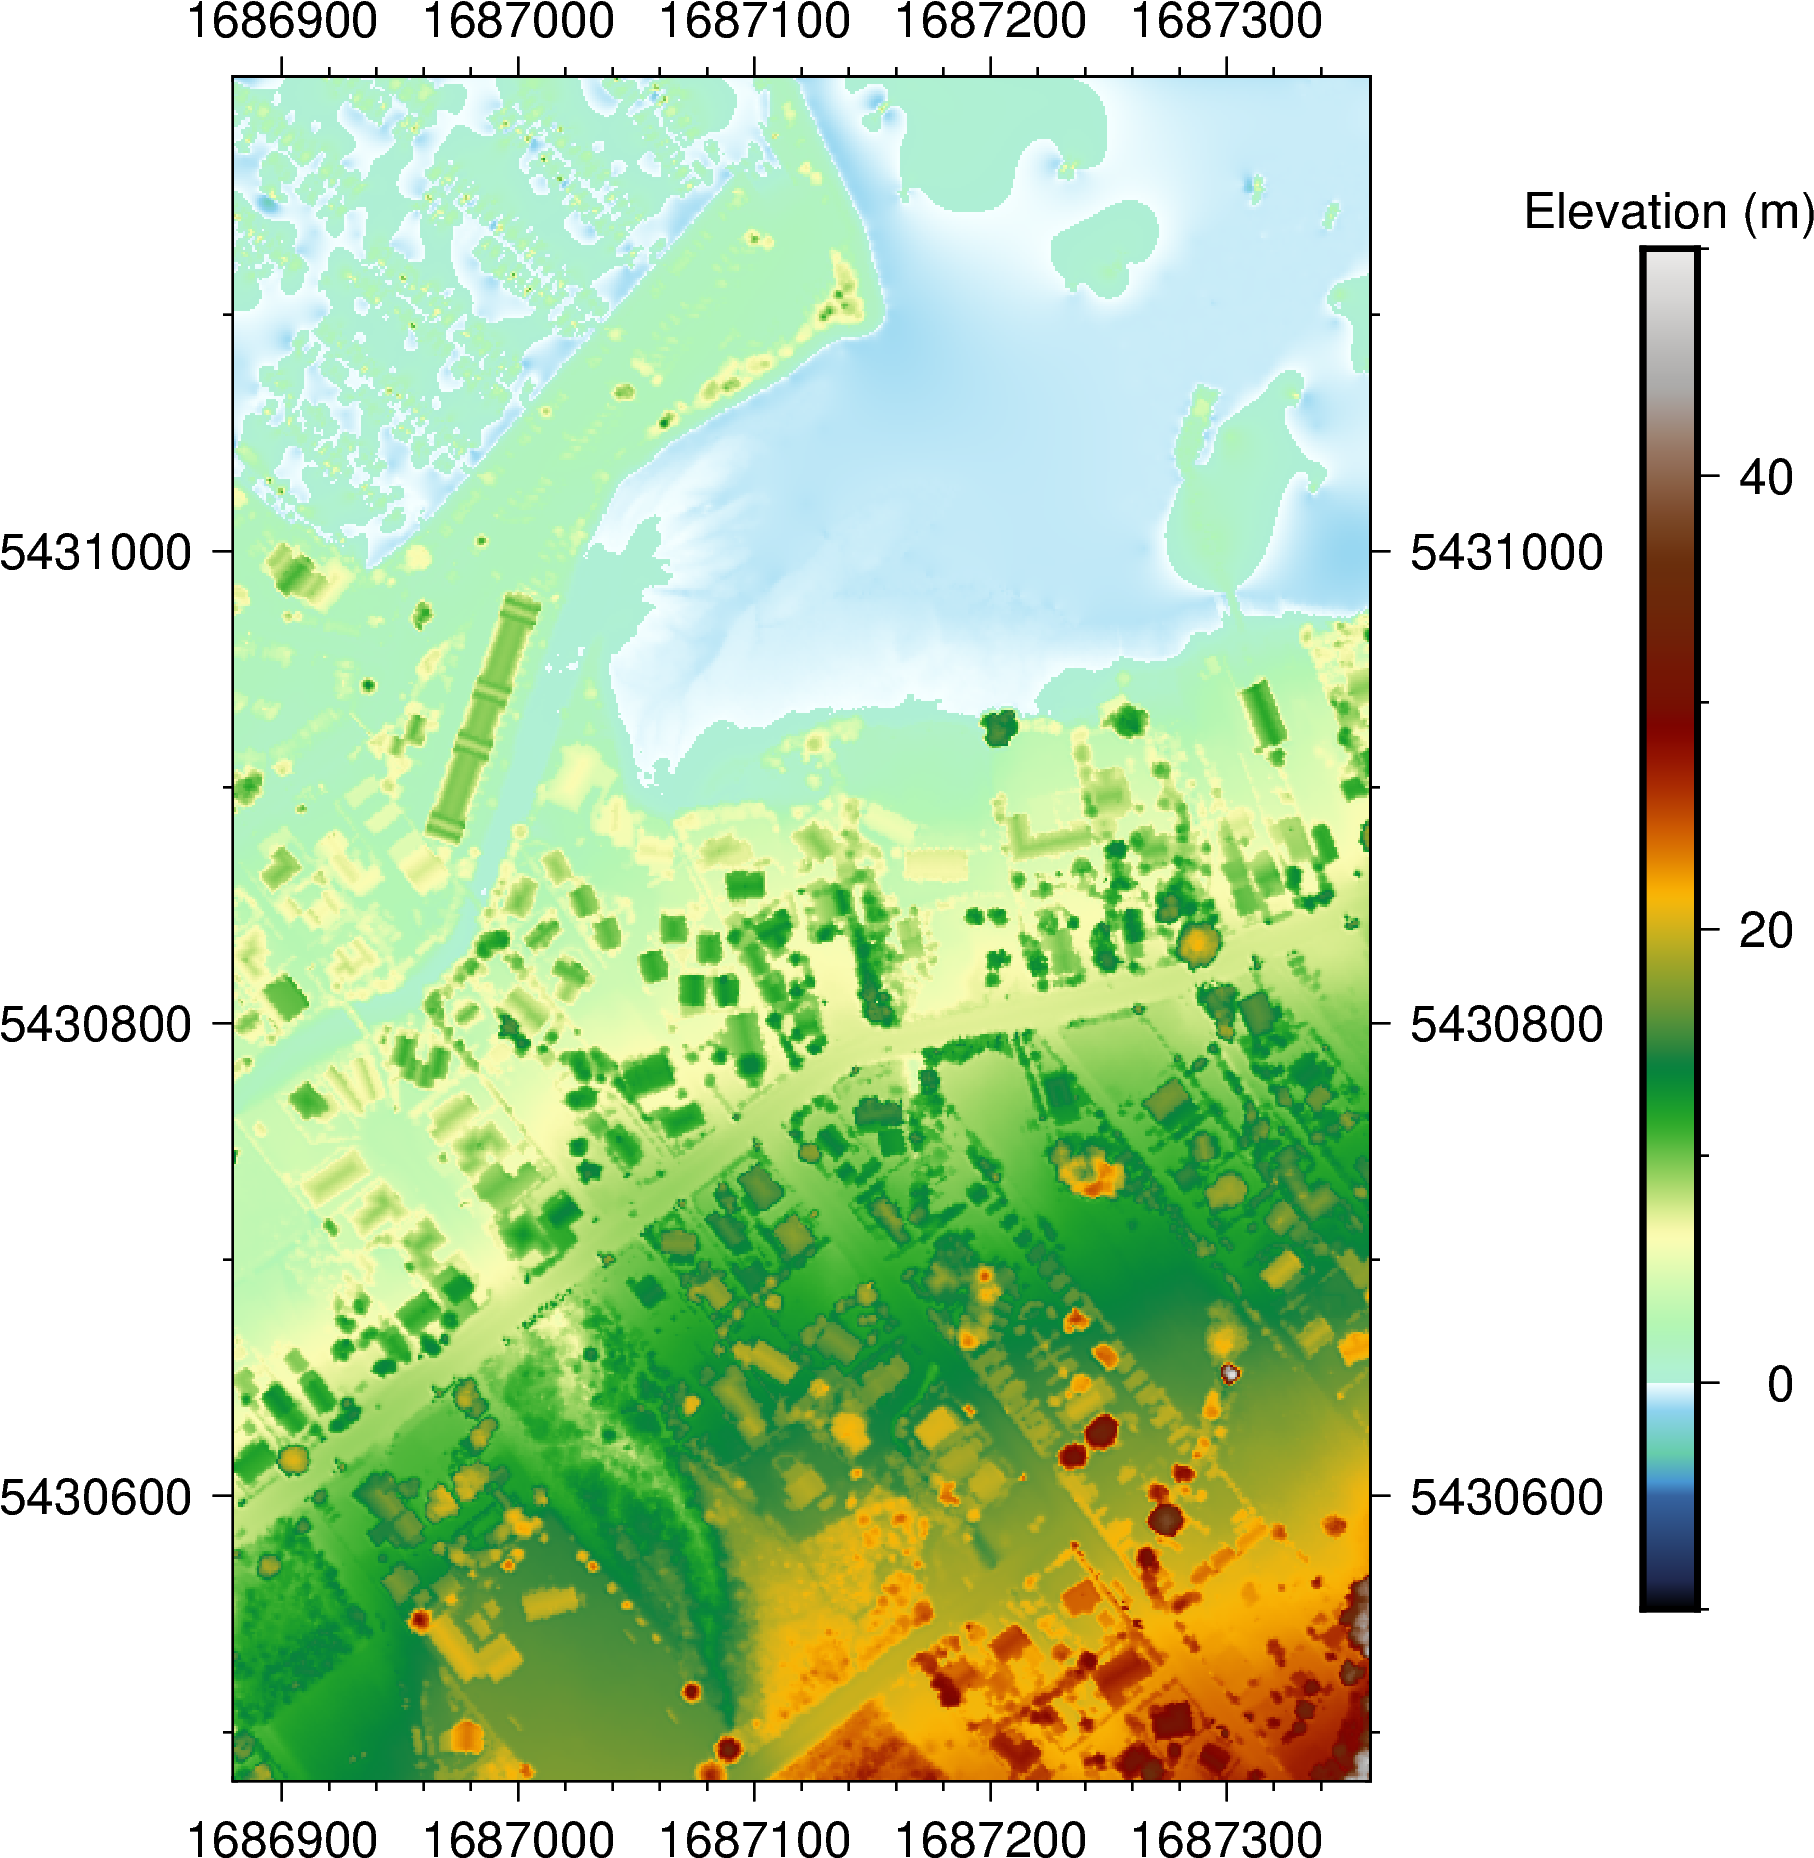

In [12]:
fig2 = pygmt.Figure()
fig2.basemap(frame=True, region=region, projection="x1:5000")
pygmt.makecpt(cmap="earth", series=[-10, 50])
fig2.grdimage(grid=grid.z)
fig2.colorbar(position="JMR", frame=["af", 'y+l"Elevation (m)"'], X="1.2c")
fig2.show()

### **Plotting a 3D perspective view!**

Now comes the cool part.
PyGMT has a [grdview](https://pygmt-git-foss4g2019oceania.gmt.now.sh/api/generated/pygmt.Figure.grdview.html#pygmt.Figure.grdview)
function that has the ability to make high quality 3D perspective plots of our elevation surface!

Besides providing the elevation 'reliefgrid', there are a few basic things to configure:
- cmap - name of colormap to use
- surftype - we'll use 's' here which just creates a regular surface
- perspective - set azimuth angle (e.g. 45 for NorthEast) and elevation (e.g 30 degrees) of the viewpoint
- zscale - a vertical exaggeration factor, we'll use 0.1 here.

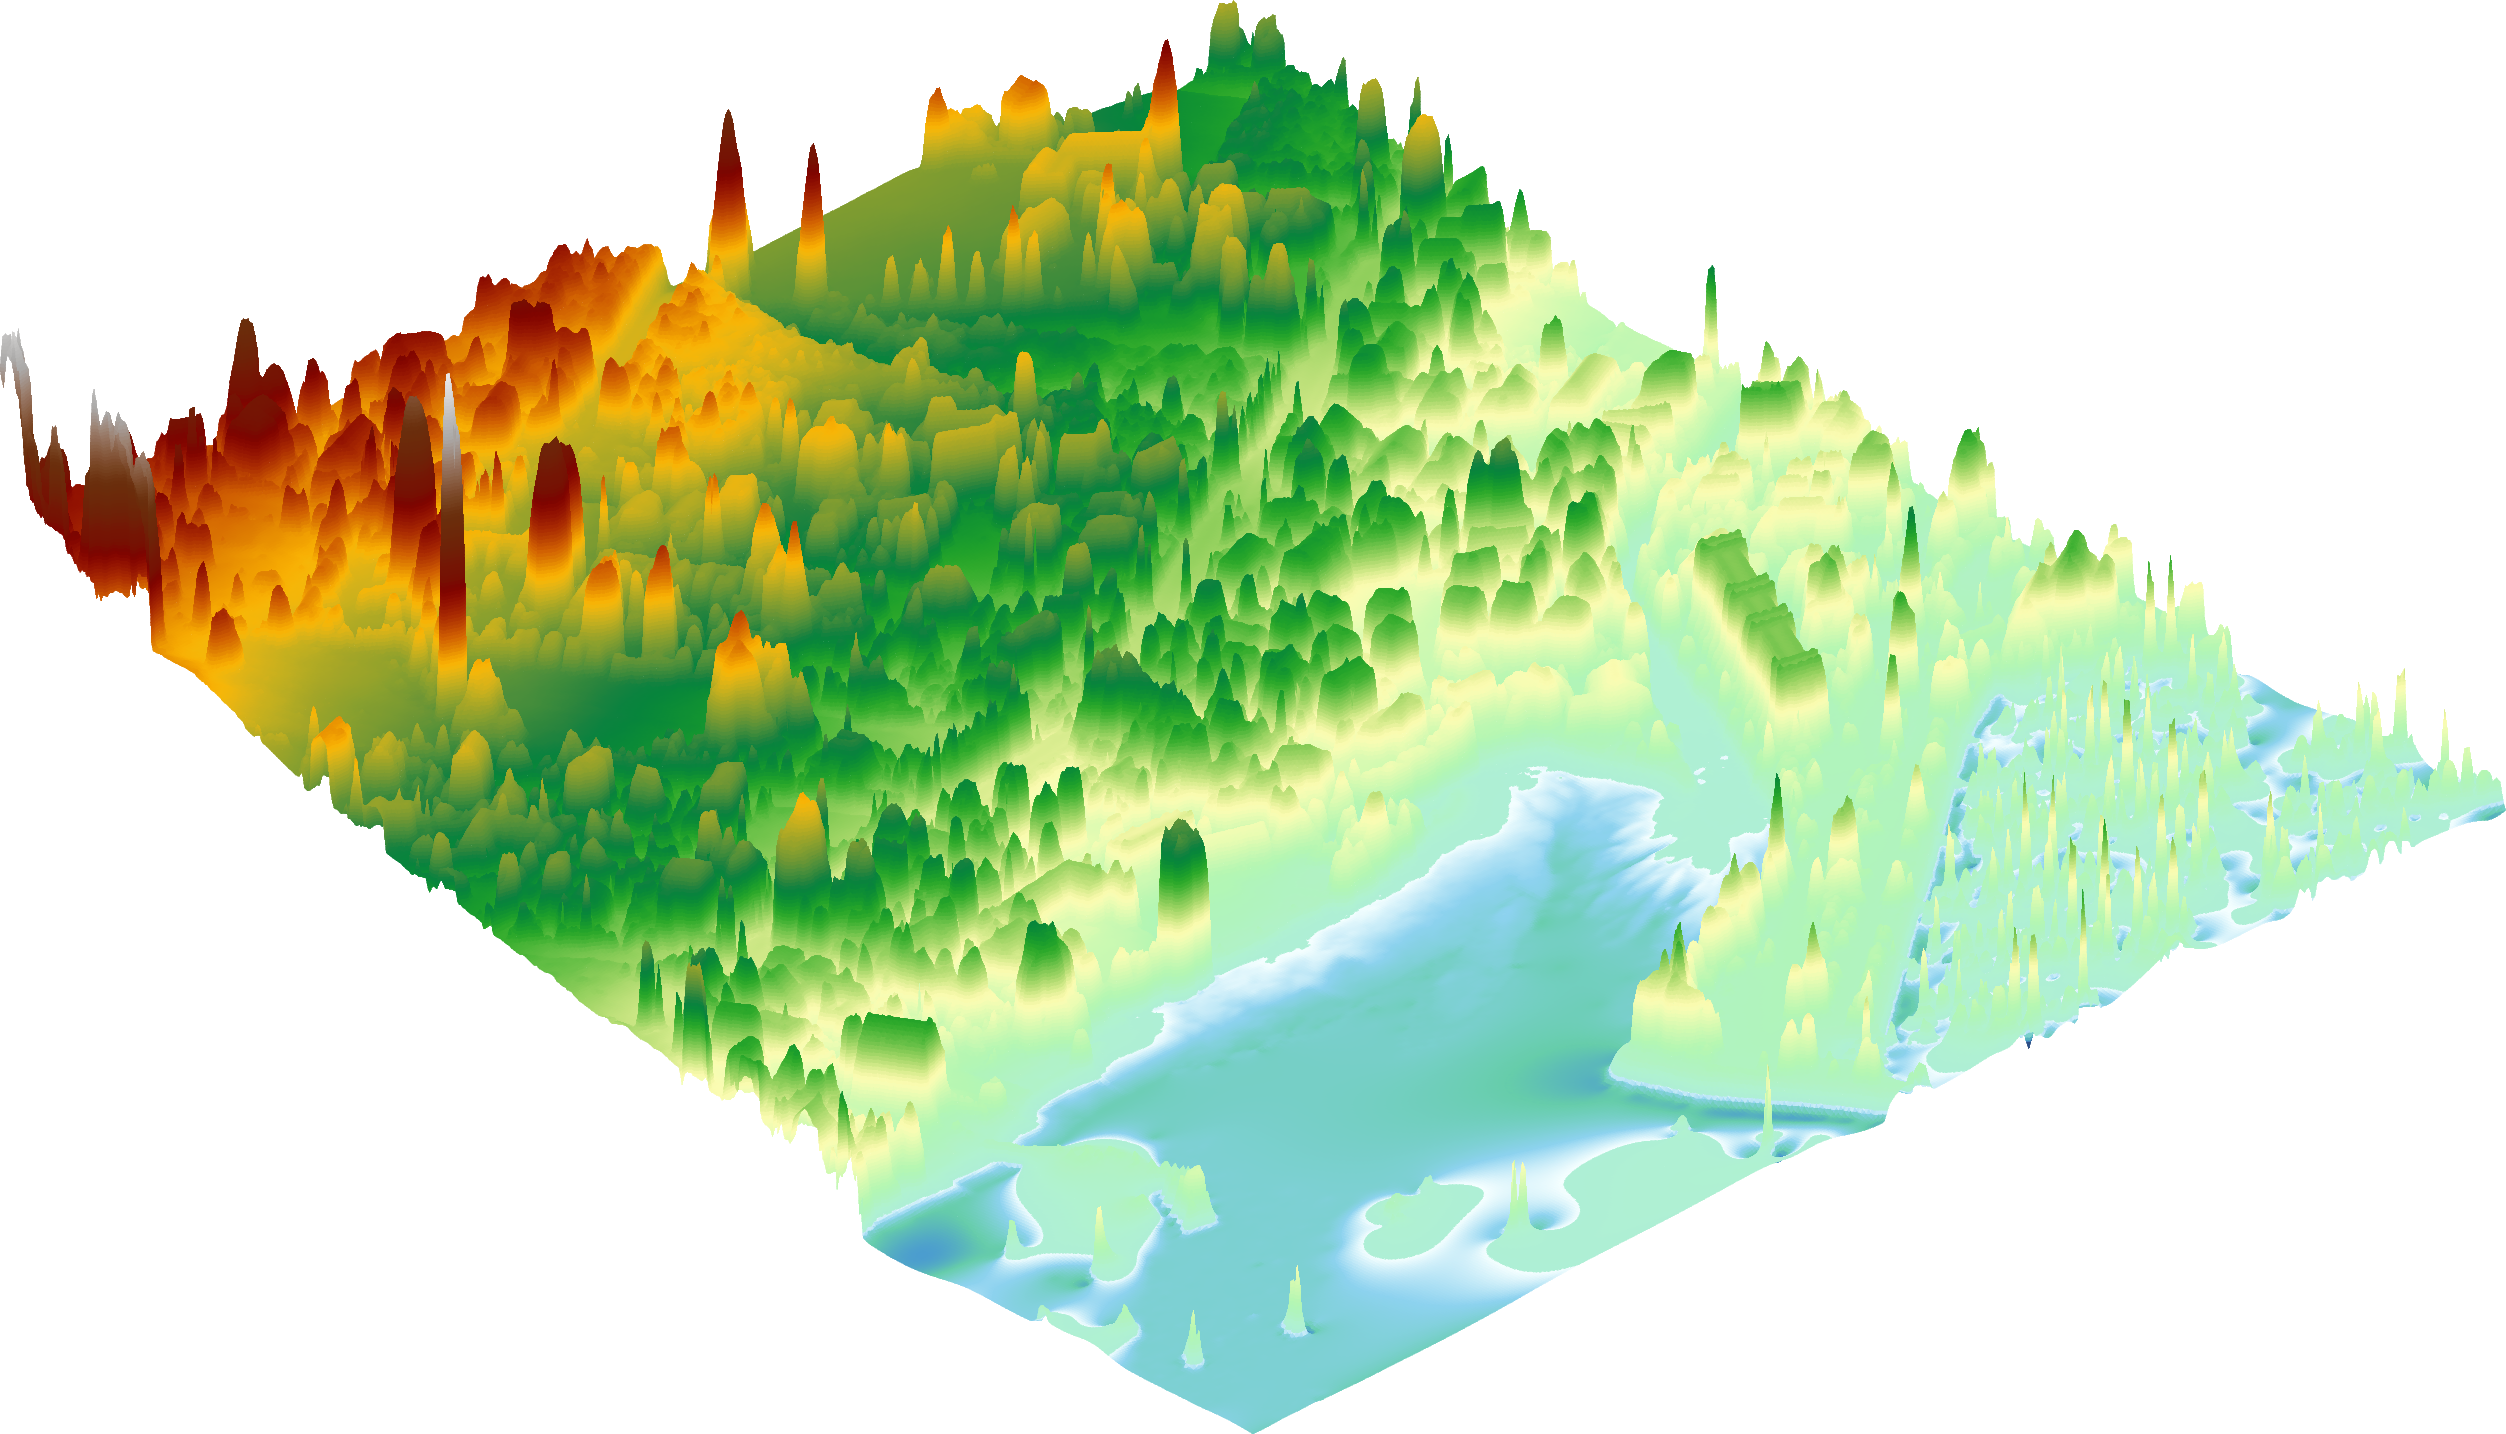

In [13]:
fig3 = pygmt.Figure()
fig3.grdview(
    reliefgrid=grid.z,
    cmap="earth",
    surftype="s",  # surface plot
    perspective=[45, 30],  # azimuth bearing, and elevation angle
    zscale=0.1,  # vertical exaggeration
)
fig3.show()

There are also other things we can add such as a proper 3D map frame with:
- automatic tick marks on x and y axis (e.g. xaf+l"Label")
- z-axis automatic tick marks (zaf+l"Label")
- plot title (+t"Title")

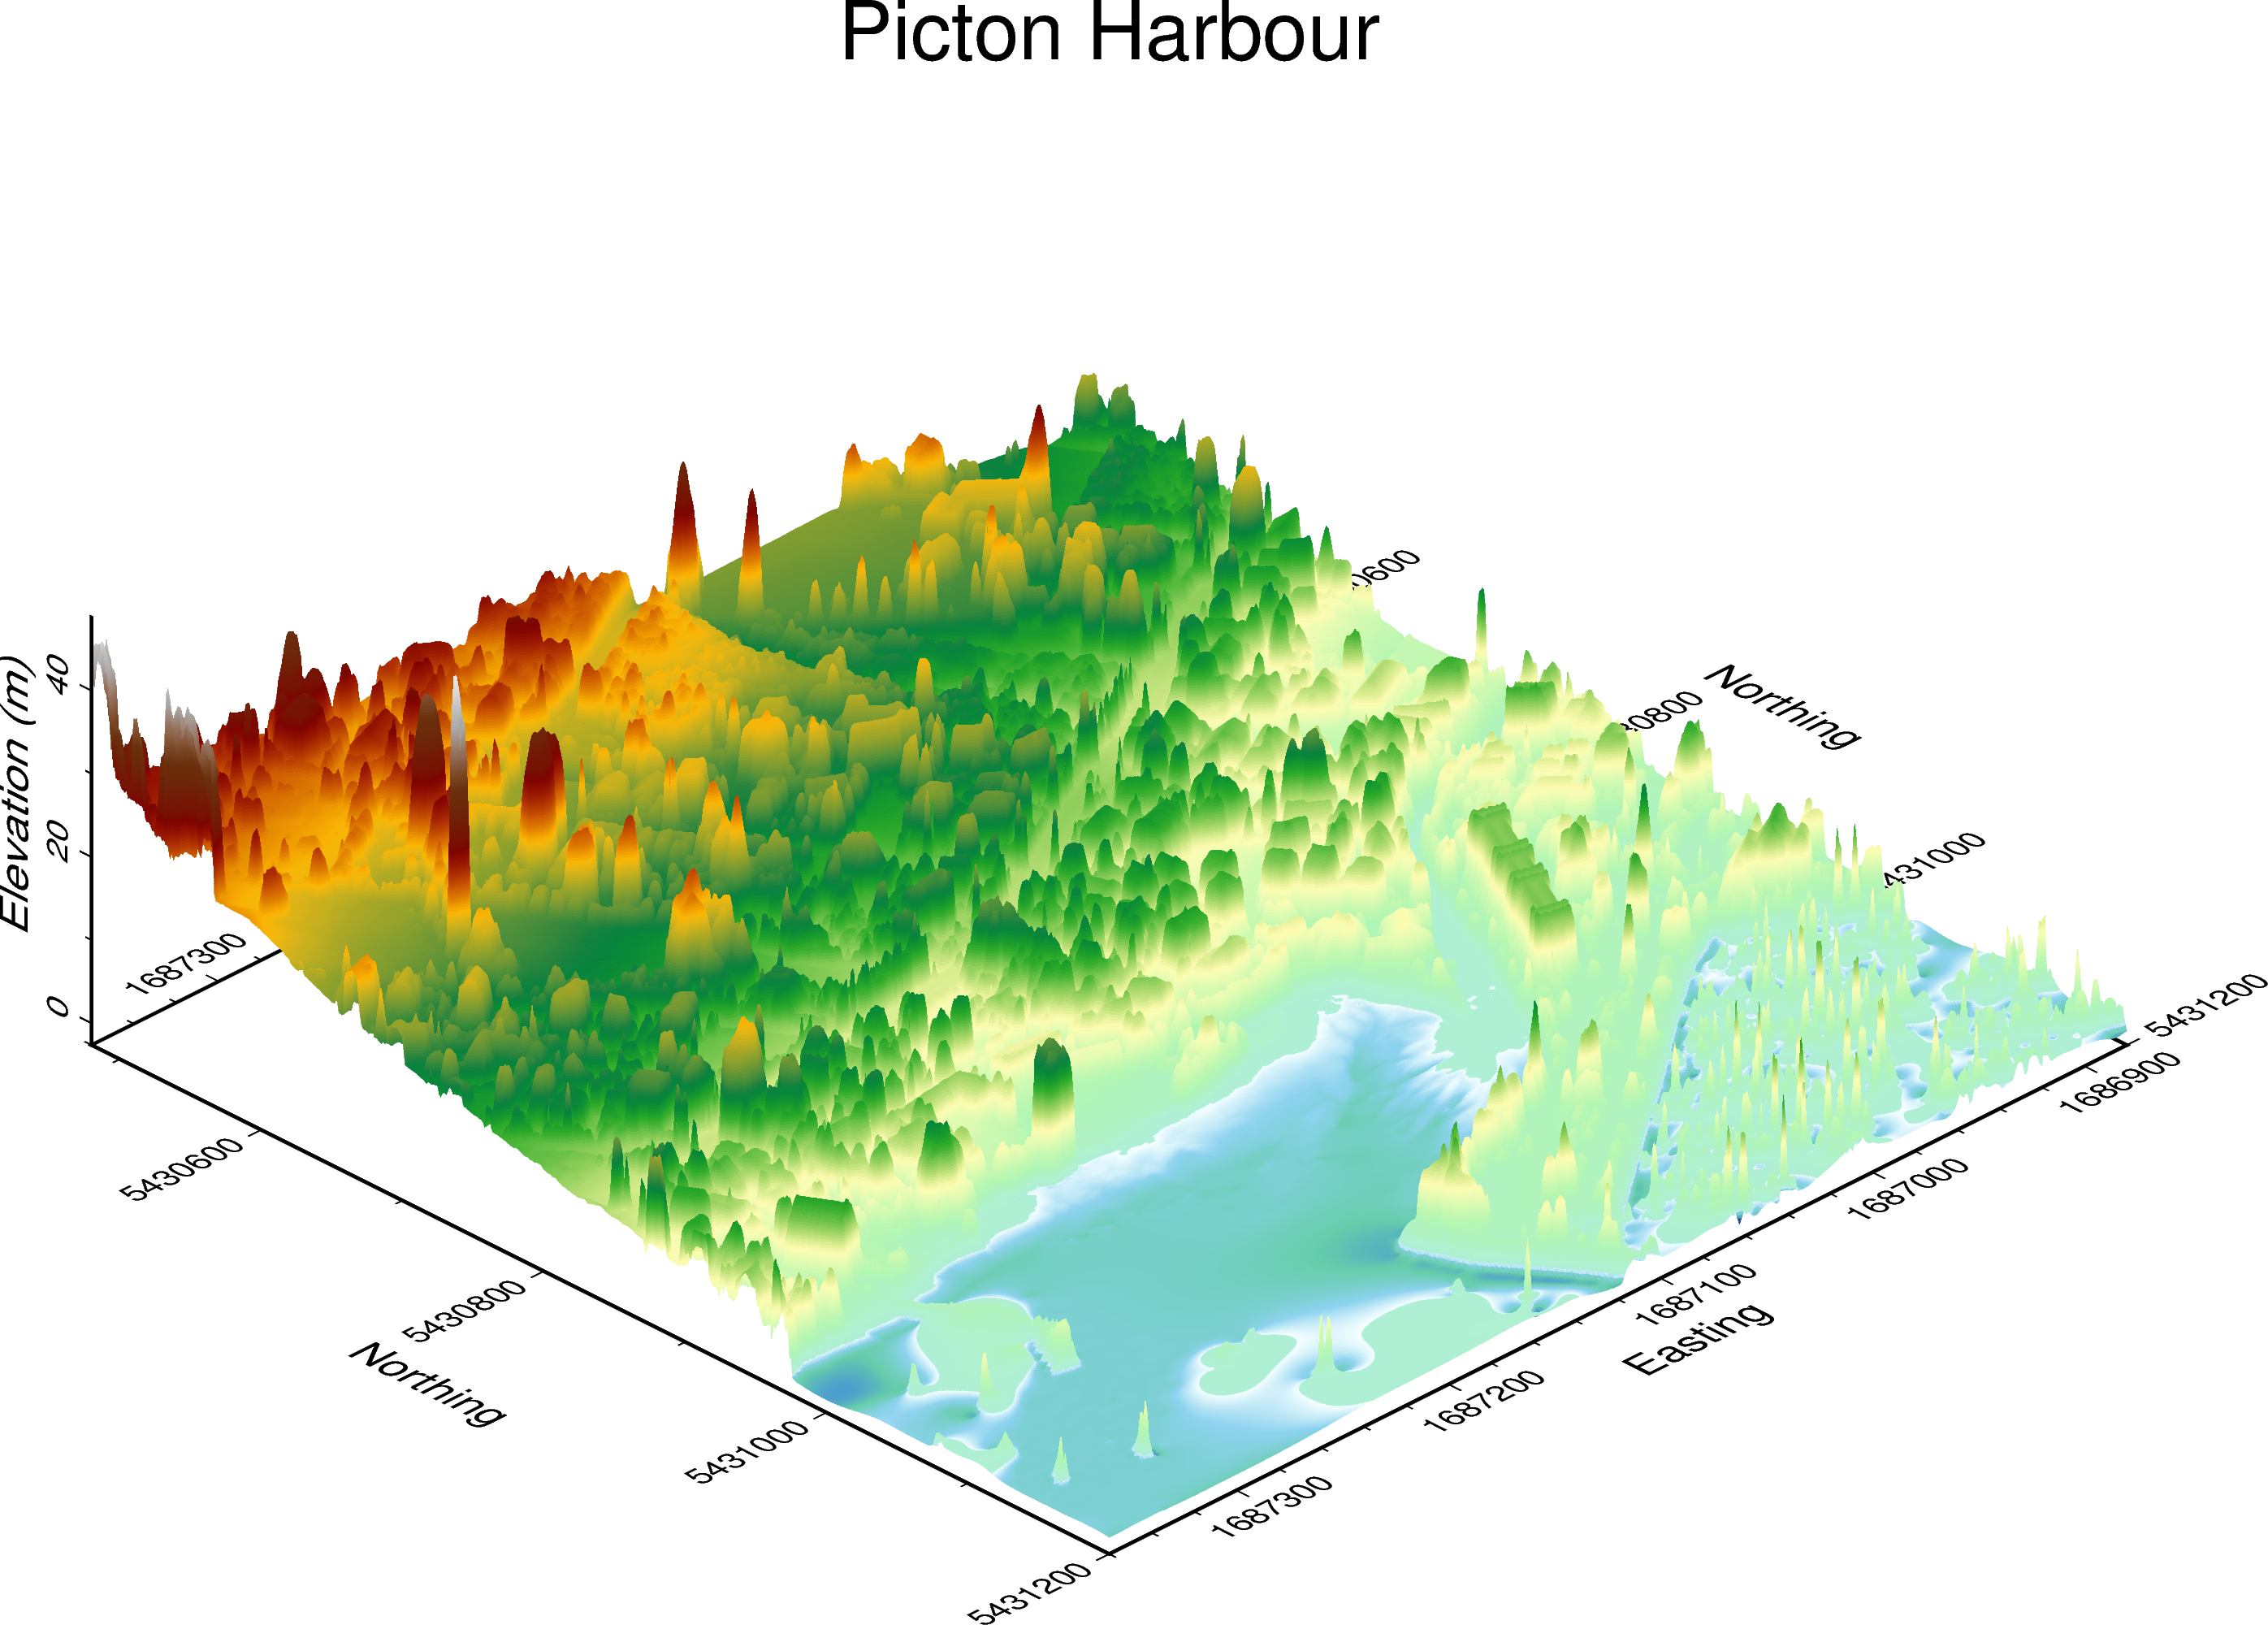

In [14]:
fig3 = pygmt.Figure()
fig3.grdview(
    reliefgrid=grid.z,
    cmap="earth",
    surftype="s",  # surface plot
    perspective=[45, 30],  # azimuth bearing, and elevation angle
    zscale=0.1,  # vertical exaggeration
    frame=['xaf+l"Easting"', 'yaf+l"Northing"', 'zaf+l"Elevation (m)"', '+t"Picton Harbour"']
)
fig3.show()

Before moving on,
have a go at changing the azimuth and elevation angle to get a different view.
Try to tweak the vertical exaggeration factor and play around with the map frame.

### **Save the figure and output DSM to a GeoTIFF**

Remember to save your work!
We'll save each of our figures into separate files first.

In [ ]:
fig.savefig(fname="picton_1d_lidar.png")
fig2.savefig(fname="picton_2d_dsm_map.png")
fig3.savefig(fname="picton_3d_dsm_view.png")

Also, it'll be good to have a proper GeoTIFF of the DSM we made.
This can be done using
[rioxarray's to_raster method](https://corteva.github.io/rioxarray/html/examples/convert_to_raster.html).

In [ ]:
grid.z.rio.to_raster(raster_path="DSM_of_Picton.tif")

The files should now appear on the file list on the left,
and you can download them to your computer.

## **3.4 Exploration time - Create a 3D surface map of another area**

Yet another challenge to test your PyGMT skills!
You'll be processing a LiDAR point cloud of a different area from start to finish.
Good luck!

Feel free to find a dataset from an area you're interested in using
[OpenTopography](http://opentopo.sdsc.edu/datasets).
To make it easier though, I've provided an example for [Queenstown, New Zealand](https://data.linz.govt.nz/layer/99121-otago-queenstown-lidar-index-tiles-2016/) below:
  (OpenTopography [link](http://opentopo.sdsc.edu/lidarDataset?opentopoID=OTLAS.012019.2193.1)):
  - https://cloud.sdsc.edu/v1/AUTH_opentopography/PC_Bulk/NZ16_Queen/CL2_CC11_2016_1000_0813.laz
  - https://cloud.sdsc.edu/v1/AUTH_opentopography/PC_Bulk/NZ16_Queen/CL2_CC11_2016_1000_0814.laz
  - https://cloud.sdsc.edu/v1/AUTH_opentopography/PC_Bulk/NZ16_Queen/CL2_CC11_2016_1000_0913.laz
  - https://cloud.sdsc.edu/v1/AUTH_opentopography/PC_Bulk/NZ16_Queen/CL2_CC11_2016_1000_0914.laz

### **Download and load data**

In [ ]:
filenames = [
    "",
]

df = pd.DataFrame()  # Start an empty DataFrame
for fname in filenames:
    lazfile = pygmt.which(
        fname=fname,
        download="l"
    )
    with laspy.file.File(lazfile, mode="r") as lasdata:
        temp_df = pd.DataFrame(data=lasdata.points["point"])
        temp_df.X = lasdata.get_x_scaled()
        temp_df.Y = lasdata.get_y_scaled()
        temp_df.Z = lasdata.get_z_scaled()
    df = df.append(temp_df, ignore_index=True)  # load each point cloud into the DataFrame

In [ ]:
df

### **Create a DSM**

### **Plot the DSM**

That's it!
We should have some spare time to cover any lingering questions in more depth.
If any of you have any questions afterwards the workshop/conference,
feel free to post them on our [community forum](https://forum.generic-mapping-tools.org)
and we'll be more than happy to assist.